## Introduction
In this exercise, you'll apply target encoding to features in the Ames dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("ames.csv")

First you'll need to choose which features you want to apply a target encoding to. Categorical features with a large number of categories are often good candidates. Run this cell to see how many categories each categorical feature in the Ames dataset has.

In [3]:
df.select_dtypes(["object"]).nunique()

MSSubClass       16
MSZoning          7
Street            2
Alley             3
LotShape          4
LandContour       4
Utilities         3
LotConfig         5
LandSlope         3
Neighborhood     28
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
OverallQual      10
OverallCond       9
RoofStyle         6
RoofMatl          8
Exterior1st      16
Exterior2nd      17
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          6
BsmtCond          6
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       5
Functional        8
FireplaceQu       6
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
PoolQC            5
Fence             5
MiscFeature       5
SaleType         10
SaleCondition     6
dtype: int64

We talked about how the M-estimate encoding uses smoothing to improve estimates for rare categories. To see how many times a category occurs in the dataset, you can use the value_counts method. This cell shows the counts for SaleType, but you might want to consider others as well.

In [4]:
df["SaleType"].value_counts()

SaleType
WD       2536
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: count, dtype: int64

## 1) Choose Features for Encoding
Which features did you identify for target encoding? After you've thought about your answer, run the next cell for some discussion.

The Neighborhood feature looks promising. It has the most categories of any feature, and several categories are rare. Others that could be worth considering are SaleType, MSSubClass, Exterior1st, Exterior2nd. In fact, almost any of the nominal features would be worth trying because of the prevalence of rare categories.

Now you'll apply a target encoding to your choice of feature. As we discussed in the tutorial, to avoid overfitting, we need to fit the encoder on data heldout from the training set. Run this cell to create the encoding and training splits:

In [5]:
# Encoding split
X_encode = df.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("SalePrice")

# Training split
X_pretrain = df.drop(X_encode.index)
y_train = X_pretrain.pop("SalePrice")

## 2) Apply M-Estimate Encoding
Apply a target encoding to your choice of categorical features. Also choose a value for the smoothing parameter m (any value is okay for a correct answer).

In [7]:
from category_encoders import MEstimateEncoder

In [8]:
# Create the MEstimateEncoder
# Choose a set of features to encode and a value for m
encoder = MEstimateEncoder(
    cols=["Neighborhood"],
    m=1.0,
)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)


If you'd like to see how the encoded feature compares to the target, you can run this cell:

/var/folders/r9/ql9ltmp52sl7886y22z1hpx00000gn/T/ipykernel_3734/2128611064.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y_train, kde=True, hist=False)
/var/folders/r9/ql9ltmp52sl7886y22z1hpx00000gn/T/ipykernel_3734/2128611064.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.d

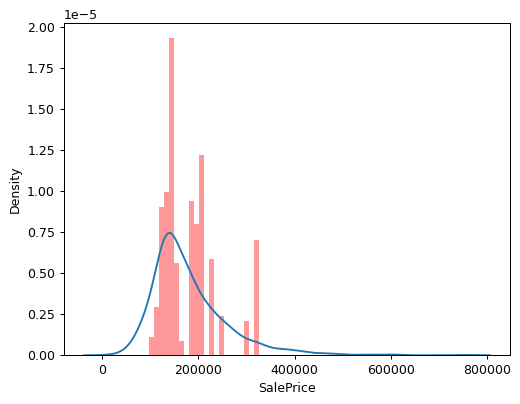

In [9]:
feature = encoder.cols

plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

From the distribution plots, does it seem like the encoding is informative?

And this cell will show you the score of the encoded set compared to the original set:

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [14]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [15]:
X = df.copy()
y = X.pop("SalePrice")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(f"Baseline Score: {score_base:.4f} RMSLE")
print(f"Score with Encoding: {score_new:.4f} RMSLE")

Baseline Score: 0.1434 RMSLE
Score with Encoding: 0.1434 RMSLE


Do you think that target encoding was worthwhile in this case? Depending on which feature or features you chose, you may have ended up with a score significantly worse than the baseline. In that case, it's likely the extra information gained by the encoding couldn't make up for the loss of data used for the encoding.

add Codeadd Markdown
In this question, you'll explore the problem of overfitting with target encodings. This will illustrate this importance of training fitting target encoders on data held-out from the training set.

So let's see what happens when we fit the encoder and the model on the same dataset. To emphasize how dramatic the overfitting can be, we'll mean-encode a feature that should have no relationship with SalePrice, a count: 0, 1, 2, 3, 4, 5, ....

In [16]:
# Try experimenting with the smoothing parameter m
# Try 0, 1, 5, 50
m = 0

X = df.copy()
y = X.pop('SalePrice')

# Create an uninformative feature
X["Count"] = range(len(X))
X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder

# fit and transform on the same dataset
encoder = MEstimateEncoder(cols="Count", m=m)
X = encoder.fit_transform(X, y)

# Results
score =  score_dataset(X, y)
print(f"Score: {score:.4f} RMSLE")

/var/folders/r9/ql9ltmp52sl7886y22z1hpx00000gn/T/ipykernel_3734/3969678515.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  X["Count"][1] = 0  # actually need one duplicate value to circumvent error-checking in MEstimateEncoder
/var/fold

Score: 0.0375 RMSLE


Almost a perfect score!

/var/folders/r9/ql9ltmp52sl7886y22z1hpx00000gn/T/ipykernel_3734/711682659.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(y, kde=True, hist=False)
/var/folders/r9/ql9ltmp52sl7886y22z1hpx00000gn/T/ipykernel_3734/711682659.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(

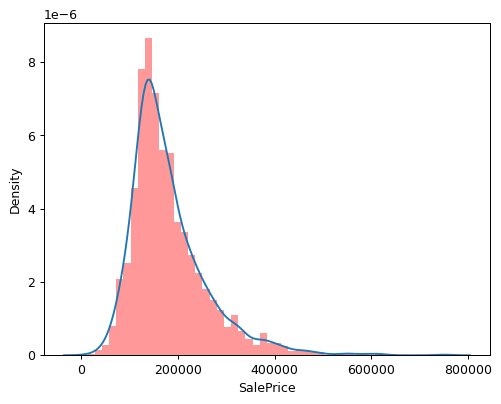

In [17]:
plt.figure(dpi=90)
ax = sns.distplot(y, kde=True, hist=False)
ax = sns.distplot(X["Count"], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("SalePrice");

And the distributions are almost exactly the same, too.

## 3) Overfitting with Target Encoders
Based on your understanding of how mean-encoding works, can you explain how XGBoost was able to get an almost a perfect fit after mean-encoding the count feature?

Since Count never has any duplicate values, the mean-encoded Count is essentially an exact copy of the target. In other words, mean-encoding turned a completely meaningless feature into a perfect feature.

Now, the only reason this worked is because we trained XGBoost on the same set we used to train the encoder. If we had used a hold-out set instead, none of this "fake" encoding would have transferred to the training data.

The lesson is that when using a target encoder it's very important to use separate data sets for training the encoder and training the model. Otherwise the results can be very disappointing!

## The End
That's it for Feature Engineering! We hope you enjoyed your time with us.

Now, are you ready to try out your new skills? Now would be a great time to join our Housing Prices Getting Started competition. We've even prepared a Bonus Lesson that collects all the work we've done together into a starter notebook.



https://www.kaggle.com/c/house-prices-advanced-regression-techniques



https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices